In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
plt.style.use(['science', 'notebook', 'grid'])
import sys
sys.path.append("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Functions")
from Feedback_Functions import read_MATFIS, re_construct

In [2]:
#This function takes in a matrix that contains all three errors for each feature under analysis from the front.
def front_eval(data):
    #load each of the three models by converting from matlab format
    torso_f = re_construct("C:\\Users\\Cian\\OneDrive\\Documents\\Imperial\\Year 4\\FYP\\Trained MATLAB FIS\\torso_s.mat")
    heel_f = re_construct("C:\\Users\\Cian\\OneDrive\\Documents\\Imperial\\Year 4\\FYP\\Trained MATLAB FIS\\heel_s.mat")
    
    #start a simulation of the first layer fis for each of the features (allowing me to evaluate each FIS)
    sim1_torso = ctrl.ControlSystemSimulation(torso_f[0])
    sim1_heel = ctrl.ControlSystemSimulation(heel_f[0])
    
    #create an array that will hold the result of each first layer FIS
    res_1 = np.zeros_like(data)
    
    #compute the result for beginning, middle and end of torso. Then store the values in res_1
    sim1_torso.input['Input0'] = data[0,:]
    sim1_torso.compute()
    res_1[0,:] = sim1_torso.output['Output0']
    
    #compute the result for beginning, middle and end of heel. Then store the values in res_1
    sim1_heel.input['Input0'] = data[1,:]
    sim1_heel.compute()
    res_1[1,:] = sim1_heel.output['Output0']
    
    #now find the overall output for each using fis21 and fis22
    #start by initiallizing the simulations.
    sim21_torso = ctrl.ControlSystemSimulation(torso_f[1])
    sim22_torso = ctrl.ControlSystemSimulation(torso_f[2])
    
    sim21_heel = ctrl.ControlSystemSimulation(heel_f[1])
    sim22_heel = ctrl.ControlSystemSimulation(heel_f[2])
    
    #create an array that will hold the overall results
    res_2 = np.zeros(2)
    
    #compute result for torso
    sim21_torso.input['Input0'] = res_1[0,0]
    sim21_torso.input['Input1'] = res_1[0,1]
    sim21_torso.compute()
    temp21 = sim21_torso.output['Output0']
    sim22_torso.input['Input0'] = temp21
    sim22_torso.input['Input1'] = res_1[0,2]
    sim22_torso.compute()
    res_2[0] = sim22_torso.output['Output0']
    
    #compute result for heel
    sim21_heel.input['Input0'] = res_1[1,0]
    sim21_heel.input['Input1'] = res_1[1,1]
    sim21_heel.compute()
    temp21 = sim21_heel.output['Output0']
    sim22_heel.input['Input0'] = temp21
    sim22_heel.input['Input1'] = res_1[1,2]
    sim22_heel.compute()
    res_2[1] = sim22_heel.output['Output0']  
    
    return res_1, res_2

Define a function that takes in the overall scores for each category, the function will make a classification that gives a verbal description of the overall score.

In [3]:
def classify(result, partial_rep):
    """
    Classifies squatting technique based on three measurements:
    - Index 0: Lateral balance (negative = left lean, positive = right lean)
    - Index 1: Foot stance width (negative = too narrow, positive = too wide)
    - Index 2: Knee alignment (negative = too close, positive = too far apart)
    
    Each measurement is classified on a scale from severe issue to correct form.
    
    Args:
        result: Array of shape (3) containing normalized scores for each metric
        
    Returns:
        List of string descriptions for each of the three metrics
    """
    # Initialize empty result descriptions for each category
    verbal_results = ["", "", "", ""]
    
    # Category names for reference
    categories = ["Rep Height", "Rep Depth", "Torso Angle", "Heel Lift"]
    
        #first give verbal feedback on partial repetition
    for i in range(2):
        if partial_rep[i] > 0.9 and partial_rep[i] <=1.1:
            if i == 0:
                verbal_results[i] = "Correct Height"
            else:
                verbal_results[i] = "Correct Depth"        
        elif partial_rep[i] > 0.8 and partial_rep[i]<=0.9:
            if i == 0:
                verbal_results[i] = "Not completing upwards repetition (moderately). Stand straighter."
            else:
                verbal_results[i] = "Not deep enough (moderately), squat deeper if safe."
        elif partial_rep[i]<=0.8:
            if i == 0:
                verbal_results[i] = "Not completing upwards repetition. Stand straighter."
            else:
                verbal_results[i] = "Not deep enough, squat deeper if safe."
                
        #Finally take into account the fact that it is possible to squat too deeply but cannot stand more than straight
        else: #if greater than 1.1
            if i == 1:
                verbal_results[i] = "Squatting may be too deep, only proceed if experienced."
    
    # Classify each metric independently
    for i in range(2):
        if result[i] > 2/3:
            if i == 0:
                verbal_results[i+2] = "Significant backwards lean"
            else:
                verbal_results[i+2] = "Significant heel lift"
        
        elif result[i] > 1/3:
            if i == 0:
                verbal_results[i+2] = "Moderate backwards lean"
            else:
                verbal_results[i+2] = "Moderate heel lift"
        
        elif result[i] >= -1/3:
            verbal_results[i+2] = "Correct"
        
        elif result[i] >= -2/3:
            if i == 0:
                verbal_results[i+2] = "Moderate forwards lean"
            else:
                verbal_results[i+2] = "Moderate heel dip"
        
        else:  # result[i] < -2/3
            if i == 0:
                verbal_results[i+2] = "Significant forwards lean"
            else:
                verbal_results[i+2] = "Significant heel dip"
    
    return verbal_results

In [10]:
torso = np.loadtxt("C:\\Users\\Cian\\Downloads\\con_torso.txt")
heel = np.loadtxt("C:\\Users\\Cian\\Downloads\\con_heel.txt")
par_rep = np.loadtxt("C:\\Users\\Cian\\Downloads\\con_par_rep.txt")

# torso = np.loadtxt("C:\\Users\\Cian\\Downloads\\ecc_torso.txt")
# heel = np.loadtxt("C:\\Users\\Cian\\Downloads\\ecc_heel.txt")
# par_rep = np.loadtxt("C:\\Users\\Cian\\Downloads\\ecc_par_rep.txt")

data = np.stack((torso, heel))
res = np.zeros((4,2,data.shape[-1]))
for i in range(data.shape[-1]):
    res1, res2 = front_eval(data[:,:,i])
    res[:-1,:,i] = res1.T
    res[-1,:,i] = res2

[-0.76668253 -0.97992649]


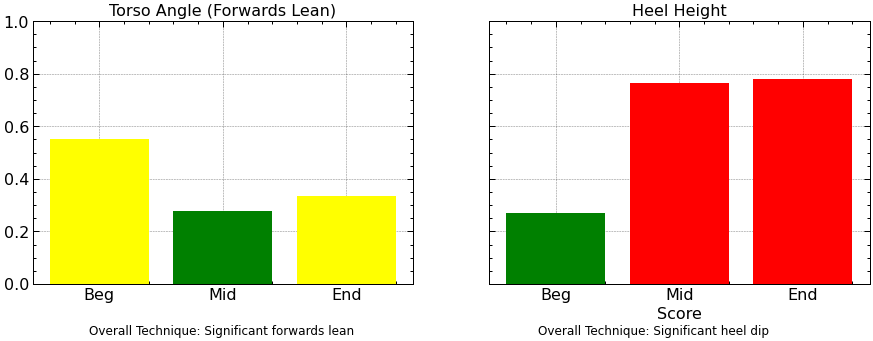

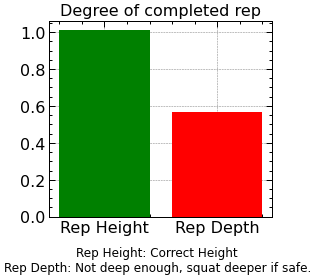

In [11]:
#now get the verbal technique analysis of each category
rep = 1
verb_tech = classify(res[-1,:,rep], par_rep[rep])
print(res[-1,:,rep])

# Define a function to determine the color based on the magnitude
def get_color(value):
    if value < 1/3:
        return 'green'
    elif value < 2/3:
        return 'yellow'
    else:
        return 'red'
#now plot the partial repetition analysis
def get_color1(val):
    if val <= 1.1 and val>0.9:
        return 'green'
    elif (val > 0.8 and val <= 0.9) or val > 1.1:
        return 'yellow'
    else:
        return 'red'
    
# Define the categories for the bar plots
cat = ['Beg', 'Mid', 'End']
    

# For the top row of plots (technique analysis)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot bars with colors based on magnitude
ax0.bar(cat, np.abs(res[:-1, 0, rep]), color=[get_color(val) for val in np.abs(res[:-1, 0, rep])])
ax1.bar(cat, np.abs(res[:-1, 1, rep]), color=[get_color(val) for val in np.abs(res[:-1, 1, rep])])

# Set y-axis limits
ax0.set_ylim(0, 1)
ax1.set_ylim(0, 1)

# Add titles to each subplot
ax0.set_title('Torso Angle (Forwards Lean)')
ax1.set_title('Heel Height')

# Add labels to the axes
ax1.set_xlabel('Score')

# Add text annotations at the figure level
plt.figtext(0.3, 0.01, f'Overall Technique: {verb_tech[2]}', ha='center', fontsize=12)
plt.figtext(0.7, 0.01, f'Overall Technique: {verb_tech[3]}', ha='center', fontsize=12)

# Adjust layout - add bottom margin for text
plt.subplots_adjust(bottom=0.15)

# For the partial repetition analysis plot
fig1, ax = plt.subplots(1, figsize=(4, 4))
ax.bar(["Rep Height", "Rep Depth"], par_rep[rep], color=[get_color1(val) for val in par_rep[rep]])
ax.set_title('Degree of completed rep')

# Add text annotations at the figure level
plt.figtext(0.5, 0.01, f'Rep Height: {verb_tech[0]}\nRep Depth: {verb_tech[1]}', ha='center', fontsize=12)

# Adjust layout - add bottom margin for text
plt.subplots_adjust(bottom=0.2)  # More space for multi-line text

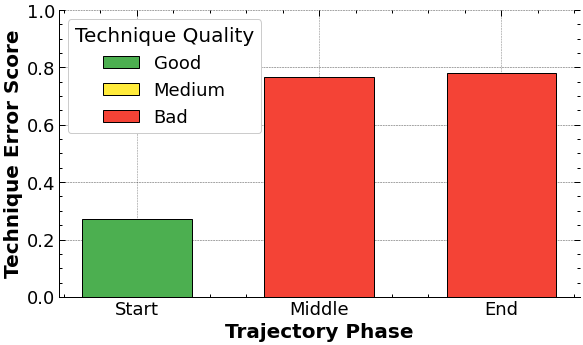

In [12]:
# Get the verbal technique analysis for heel height (adjust index as needed)
rep = 1
verb_tech = classify(res[-1,:,rep], par_rep[rep])

# Define color function
def get_color(value):
    if value < 1/3:
        return '#4CAF50'  # Green
    elif value < 2/3:
        return '#FFEB3B'  # Yellow
    else:
        return '#F44336'  # Red

# Define categories
cat = ['Start', 'Middle', 'End']

# Data for heel height (use feature index 1)
heel_data = np.abs(res[:-1, 1, rep])

# Create the plot
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8.3, 5))
bar_width = 0.6
edge_color = 'black'

ax.bar(cat, heel_data, width=bar_width, color=[get_color(val) for val in heel_data], edgecolor=edge_color)
ax.set_ylim(0, 1)
ax.set_ylabel('Technique Error Score', fontsize=20, weight='bold')  # Bold Y-axis label
ax.set_xlabel('Trajectory Phase', fontsize=20, weight='bold')      # Bold X-axis label
ax.tick_params(axis='both', which='major', labelsize=18)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a simple color legend
legend_elements = [
    Patch(facecolor='#4CAF50', edgecolor='black', label='Good'),
    Patch(facecolor='#FFEB3B', edgecolor='black', label='Medium'),
    Patch(facecolor='#F44336', edgecolor='black', label='Bad')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=18, title='Technique Quality', title_fontsize=20)

plt.tight_layout()
plt.savefig("C:\\Users\\Cian\\Downloads\\final_feedback_heel.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()
